In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing, svm
from sklearn.decomposition import PCA
from sklearn import metrics

# Part 1: Prerequisite Functions 

## Confusion Matrix

In [31]:
def confusion_matrix(y, y_pred, title):
    confusion_matrix = metrics.confusion_matrix(y, y_pred, labels=None)
    x = [1, 2, 6, 7, 8]
    class_names = ['${:d}$'.format(i) for i in x]  # Digit class names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Show class labels on each axis
    ax.xaxis.tick_top()
    major_ticks = range(0,5)
    minor_ticks = [x + 0.5 for x in range(0, 5)]
    ax.xaxis.set_ticks(major_ticks, minor=False)
    ax.yaxis.set_ticks(major_ticks, minor=False)
    ax.xaxis.set_ticks(minor_ticks, minor=True)
    ax.yaxis.set_ticks(minor_ticks, minor=True)
    ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    # Set plot labels
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    fig.suptitle(title, y=1.04, fontsize=14, ha='center', fontweight='bold')
    # Show a grid to seperate digits
    ax.grid(b=True, which=u'minor')
    # Color each grid cell according to the number classes predicted
    ax.imshow(confusion_matrix, interpolation='nearest', cmap='binary')
    # Show the number of samples in each cell
    for x in range(confusion_matrix.shape[0]):
        for y in range(confusion_matrix.shape[1]):
            color = 'w' if x == y else 'k'
            ax.text(x, y, confusion_matrix[y,x], ha="center", va="bottom", color=color)       
    plt.show()

In [38]:
def confusion_matrix2(y, y_pred, title):
    confusion_matrix = metrics.confusion_matrix(y, y_pred, labels=None)
    x = list(range(1, 22))
    class_names = ['${:d}$'.format(i) for i in x]  # Digit class names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Show class labels on each axis
    ax.xaxis.tick_top()
    major_ticks = range(0,21)
    minor_ticks = [x + 0.5 for x in range(0, 21)]
    ax.xaxis.set_ticks(major_ticks, minor=False)
    ax.yaxis.set_ticks(major_ticks, minor=False)
    ax.xaxis.set_ticks(minor_ticks, minor=True)
    ax.yaxis.set_ticks(minor_ticks, minor=True)
    ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=8)
    ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=8)
    # Set plot labels
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Predicted label', fontsize=12)
    ax.set_ylabel('True label', fontsize=12)
    fig.suptitle(title, y=1.04, fontsize=8, ha='center', fontweight='bold')
    # Show a grid to seperate digits
    ax.grid(b=True, which=u'minor')
    # Color each grid cell according to the number classes predicted
    ax.imshow(confusion_matrix, interpolation='nearest', cmap='binary')
    # Show the number of samples in each cell
    for x in range(confusion_matrix.shape[0]):
        for y in range(confusion_matrix.shape[1]):
            color = 'w' if x == y else 'k'
            ax.text(x, y, confusion_matrix[y,x], ha="center", va="bottom", color=color, fontsize=6)       
    plt.show()

# Part 1: Neural Network Models. 

In [3]:
torch.manual_seed(1234)

batch_size = 64
input_dim = 52
output_dim = 5
output_dim2 = 22

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
class myDataset(Dataset):
    def __init__(self, path):
        data = np.array(pd.read_csv(path), dtype=np.float32)
        self.X = data[:, :-1]
        self.X = (self.X - np.mean(self.X, axis=0)) / np.std(self.X, axis=0)
        self.Sigma = self.X.T.dot(self.X)
        self.value, self.loading = np.linalg.eigh(self.Sigma)
        self.score = self.X.dot(self.loading)
        self.Y = data[:, -1]
        self.Y = np.array(self.Y, dtype=np.int64)
        self.length = data.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return self.length


trainDataset = myDataset('train.csv')
testDataset = myDataset('test.csv')
trainLoader = DataLoader(
    dataset=trainDataset,
    batch_size=batch_size,
    shuffle=True,
)
testLoader = DataLoader(
    dataset=testDataset,
    batch_size=batch_size,
    shuffle=True,
)

trainAllDataset = myDataset('train_all.csv')
testAllDataset = myDataset('test_all.csv')
trainAllLoader = DataLoader(
    dataset=trainAllDataset,
    batch_size=batch_size,
    shuffle=True,
)
testAllLoader = DataLoader(
    dataset=testAllDataset,
    batch_size=batch_size,
    shuffle=True,
)


## ANN (Artificial Neural Network)

In [5]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)


In [6]:
class ANN2(nn.Module):
    def __init__(self):
        super(ANN2, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.softmax(x, dim=1)

## CNN (Convolutional Neural Network)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=4),           
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(2))
        self.fc1 = nn.Linear(16*9, 16)
        self.fc2 = nn.Linear(16, output_dim)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        

In [8]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=4),           
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool1d(2))
        self.fc1 = nn.Linear(16*9, 16)
        self.fc2 = nn.Linear(16, output_dim2)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

# Part2: Functions of Training and Testing

In [9]:
epochs = 100
lr = 1e-3

trainLoss = []
testLoss = []
trainAccu = []
testAccu = []

def train(net, optimizer, criterion, trainLoader, epoch):
    net.train()
    correct = 0
    epoch_loss = 0
    for batch_idx, (x, y) in enumerate(trainLoader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, pred = torch.max(y_pred.data, 1)
        correct += (pred == y).sum().item()
        # if batch_idx % 20 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
        #         epoch, batch_idx*len(x), len(trainLoader.dataset),
        #         100. * batch_idx / len(trainLoader), loss.item()))
        #     trainLoss.append(loss.item())
    trainAccu.append(100. * correct / len(trainLoader.dataset))
    trainLoss.append(epoch_loss / len(trainLoader.dataset))
    print('Train: Epoch: {} | Loss: {:.6f} | Accuracy: {}/{} ({:.3f}%)'.format(
        epoch, epoch_loss / len(trainLoader.dataset), correct, len(trainLoader.dataset),
        100. * correct / len(trainLoader.dataset)
    ))

def test(net, criterion, testLoader):
    loss = 0
    correct = 0
    net.eval()
    with torch.no_grad():
        for x, y in testLoader:
            x = x.to(device)
            y = y.to(device)
            y_pred = net(x)
            loss += criterion(y_pred, y).item()
            _, pred = torch.max(y_pred.data, 1)
            correct += (pred == y).sum().item()
    loss /= len(testLoader.dataset)
    testLoss.append(loss)
    testAccu.append(100. * correct / len(testLoader.dataset))
    print('Test: Avg loss {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        loss, correct, len(testLoader.dataset),
        100. * correct / len(testLoader.dataset) 
    ))

# Part3: Result of classifying 5 classes of faults (1st 2nd 6th 7th 8th)

## ANN Result

In [10]:
net = ANN().to(device)

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

net

ANN(
  (fc1): Linear(in_features=52, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [11]:
trainLoss = []
testLoss = []
trainAccu = []
testAccu = []

for epoch in range(1, epochs):
    train(net, optimizer, criterion, trainLoader,epoch)
    pred = test(net, criterion, testLoader)

Train: Epoch: 1 | Loss: 0.024852 | Accuracy: 730/2400 (30.417%)
Test: Avg loss 0.0235, Accuracy: 2871/7200 (39.8750%)

Train: Epoch: 2 | Loss: 0.022455 | Accuracy: 1163/2400 (48.458%)
Test: Avg loss 0.0214, Accuracy: 3901/7200 (54.1806%)

Train: Epoch: 3 | Loss: 0.020822 | Accuracy: 1389/2400 (57.875%)
Test: Avg loss 0.0202, Accuracy: 3963/7200 (55.0417%)

Train: Epoch: 4 | Loss: 0.019895 | Accuracy: 1493/2400 (62.208%)
Test: Avg loss 0.0195, Accuracy: 4631/7200 (64.3194%)

Train: Epoch: 5 | Loss: 0.019191 | Accuracy: 1663/2400 (69.292%)
Test: Avg loss 0.0190, Accuracy: 4883/7200 (67.8194%)

Train: Epoch: 6 | Loss: 0.018591 | Accuracy: 1740/2400 (72.500%)
Test: Avg loss 0.0186, Accuracy: 4989/7200 (69.2917%)

Train: Epoch: 7 | Loss: 0.018160 | Accuracy: 1892/2400 (78.833%)
Test: Avg loss 0.0181, Accuracy: 5624/7200 (78.1111%)

Train: Epoch: 8 | Loss: 0.017483 | Accuracy: 2055/2400 (85.625%)
Test: Avg loss 0.0176, Accuracy: 6139/7200 (85.2639%)

Train: Epoch: 9 | Loss: 0.016896 | Accura

for epoch in range(1, epochs+1):
    train(net, epoch)

Text(0.5, 1.0, 'Loss of ANN of 5 cls')

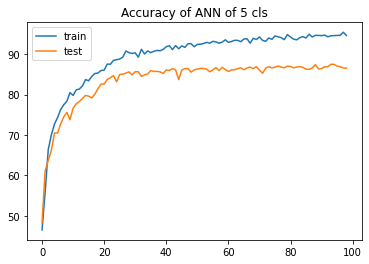

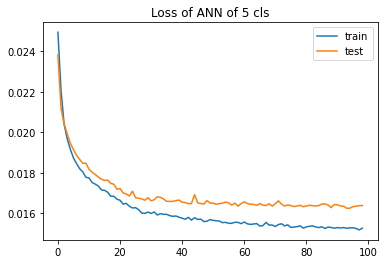

In [15]:
plt.figure(1)
plt.plot(trainAccu)
plt.plot(testAccu)
plt.legend(['train', 'test'])
plt.title('Accuracy of ANN of 5 cls')

plt.figure(2)
plt.plot(trainLoss)
plt.plot(testLoss)
plt.legend(['train', 'test'])
plt.title('Loss of ANN of 5 cls')

## CNN Result

In [17]:
net2 = CNN().to(device)

optimizer = optim.Adam(net2.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

net2

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(4,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=5, bias=True)
)

In [18]:
trainLoss = []
testLoss = []
trainAccu = []
testAccu = []

for epoch in range(1, epochs):
    train(net2, optimizer, criterion, trainLoader, epoch)
    pred = test(net2, criterion, testLoader)

Train: Epoch: 1 | Loss: 0.024399 | Accuracy: 689/2400 (28.708%)
Test: Avg loss 0.0231, Accuracy: 2655/7200 (36.8750%)

Train: Epoch: 2 | Loss: 0.021955 | Accuracy: 1189/2400 (49.542%)
Test: Avg loss 0.0213, Accuracy: 4221/7200 (58.6250%)

Train: Epoch: 3 | Loss: 0.020461 | Accuracy: 1521/2400 (63.375%)
Test: Avg loss 0.0204, Accuracy: 4427/7200 (61.4861%)

Train: Epoch: 4 | Loss: 0.019656 | Accuracy: 1624/2400 (67.667%)
Test: Avg loss 0.0198, Accuracy: 4973/7200 (69.0694%)

Train: Epoch: 5 | Loss: 0.019119 | Accuracy: 1718/2400 (71.583%)
Test: Avg loss 0.0193, Accuracy: 5165/7200 (71.7361%)

Train: Epoch: 6 | Loss: 0.018548 | Accuracy: 1855/2400 (77.292%)
Test: Avg loss 0.0190, Accuracy: 5136/7200 (71.3333%)

Train: Epoch: 7 | Loss: 0.018119 | Accuracy: 1918/2400 (79.917%)
Test: Avg loss 0.0188, Accuracy: 5074/7200 (70.4722%)

Train: Epoch: 8 | Loss: 0.017774 | Accuracy: 1926/2400 (80.250%)
Test: Avg loss 0.0181, Accuracy: 5787/7200 (80.3750%)

Train: Epoch: 9 | Loss: 0.017341 | Accura

Text(0.5, 1.0, 'Loss of CNN of 5 cls')

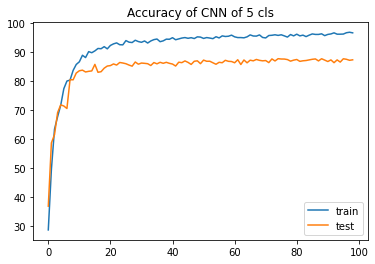

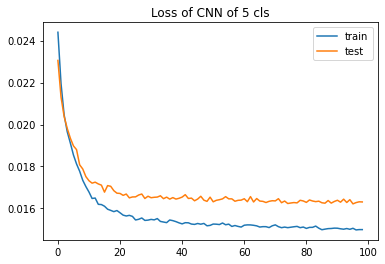

In [19]:
plt.figure(1)
plt.plot(trainAccu)
plt.plot(testAccu)
plt.legend(['train', 'test'])
plt.title('Accuracy of CNN of 5 cls')

plt.figure(2)
plt.plot(trainLoss)
plt.plot(testLoss)
plt.legend(['train', 'test'])
plt.title('Loss of CNN of 5 cls')

# Part2: Dimensional Reduction: PCA

In [20]:
def PCA_TE(n, train_x, train_y, test_x, test_y):
    mat = PCA(n)
    mat.fit(train_x)
    train_x = mat.transform(train_x)
    test_x = mat.transform(test_x)

    clf = svm.SVC(probability=True)
    clf.fit(train_x, train_y)
    pca_pred = clf.predict(test_x)
    print('accuracy: {:0.3f}'.format(np.mean(test_y == pca_pred)))
    
    return pca_pred 

accuracy: 0.888


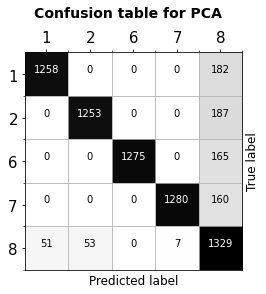

In [29]:
trainData = np.array(pd.read_csv('train.csv'), dtype=np.float32)
testData = np.array(pd.read_csv('test.csv'), dtype=np.float32)
train_x = trainData[:, :-1]
test_x = testData[:, :-1]
train_x = (train_x - np.mean(train_x, axis=0)) / np.std(train_x, axis=0)
test_x = (test_x - np.mean(test_x, axis=0)) / np.std(test_x, axis=0)
train_y = trainData[:, -1]
train_y = np.array(train_y, dtype=np.int64)
test_y = testData[:, -1]
test_y = np.array(test_y, dtype=np.int64)

n_pc = 30

pca = PCA_TE(n_pc, train_x, train_y, test_x, test_y)
confusion_matrix(test_y, pca, 'Confusion table for PCA')

# Part4: Result of classifying 22 classes of conditions (1 normal condition + 21 faults)

## ANN Result

In [22]:
net3 = ANN2().to(device)
optimizer = optim.Adam(net3.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

net3

ANN2(
  (fc1): Linear(in_features=52, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=22, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [23]:
trainLoss = []
testLoss = []
trainAccu = []
testAccu = []

for epoch in range(1, epochs):
    train(net3, optimizer, criterion, trainAllLoader, epoch)
    pred = test(net3, criterion, testAllLoader)

Train: Epoch: 1 | Loss: 0.047242 | Accuracy: 1516/10580 (14.329%)
Test: Avg loss 0.0462, Accuracy: 5434/31700 (17.1420%)

Train: Epoch: 2 | Loss: 0.045735 | Accuracy: 2422/10580 (22.892%)
Test: Avg loss 0.0456, Accuracy: 7045/31700 (22.2240%)

Train: Epoch: 3 | Loss: 0.045257 | Accuracy: 2740/10580 (25.898%)
Test: Avg loss 0.0454, Accuracy: 7459/31700 (23.5300%)

Train: Epoch: 4 | Loss: 0.044999 | Accuracy: 2919/10580 (27.590%)
Test: Avg loss 0.0452, Accuracy: 8353/31700 (26.3502%)

Train: Epoch: 5 | Loss: 0.044621 | Accuracy: 3450/10580 (32.609%)
Test: Avg loss 0.0447, Accuracy: 9663/31700 (30.4826%)

Train: Epoch: 6 | Loss: 0.044106 | Accuracy: 3858/10580 (36.465%)
Test: Avg loss 0.0444, Accuracy: 10388/31700 (32.7697%)

Train: Epoch: 7 | Loss: 0.043825 | Accuracy: 4041/10580 (38.195%)
Test: Avg loss 0.0443, Accuracy: 10407/31700 (32.8297%)

Train: Epoch: 8 | Loss: 0.043682 | Accuracy: 4176/10580 (39.471%)
Test: Avg loss 0.0442, Accuracy: 10887/31700 (34.3438%)

Train: Epoch: 9 | Los

Text(0.5, 1.0, 'Loss of ANN of 22 cls')

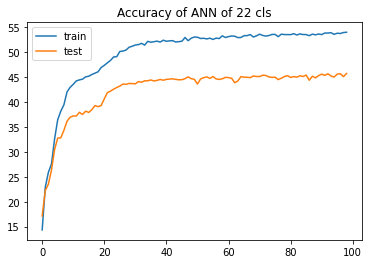

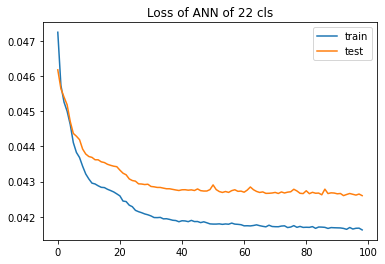

In [24]:
plt.figure(1)
plt.plot(trainAccu)
plt.plot(testAccu)
plt.legend(['train', 'test'])
plt.title('Accuracy of ANN of 22 cls')

plt.figure(2)
plt.plot(trainLoss)
plt.plot(testLoss)
plt.legend(['train', 'test'])
plt.title('Loss of ANN of 22 cls')

## CNN Result

In [25]:
net4 = CNN2().to(device)
optimizer = optim.Adam(net4.parameters(), lr=lr, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

net4

CNN2(
  (layer1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(4,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=144, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=22, bias=True)
)

In [26]:
trainLoss = []
testLoss = []
trainAccu = []
testAccu = []

for epoch in range(1, epochs):
    train(net4, optimizer, criterion, trainAllLoader, epoch)
    pred = test(net4, criterion, testAllLoader)

Train: Epoch: 1 | Loss: 0.047669 | Accuracy: 1290/10580 (12.193%)
Test: Avg loss 0.0467, Accuracy: 5334/31700 (16.8265%)

Train: Epoch: 2 | Loss: 0.046270 | Accuracy: 2067/10580 (19.537%)
Test: Avg loss 0.0463, Accuracy: 6215/31700 (19.6057%)

Train: Epoch: 3 | Loss: 0.045905 | Accuracy: 2381/10580 (22.505%)
Test: Avg loss 0.0460, Accuracy: 6847/31700 (21.5994%)

Train: Epoch: 4 | Loss: 0.045659 | Accuracy: 2676/10580 (25.293%)
Test: Avg loss 0.0458, Accuracy: 7564/31700 (23.8612%)

Train: Epoch: 5 | Loss: 0.045420 | Accuracy: 2862/10580 (27.051%)
Test: Avg loss 0.0457, Accuracy: 7892/31700 (24.8959%)

Train: Epoch: 6 | Loss: 0.045237 | Accuracy: 3007/10580 (28.422%)
Test: Avg loss 0.0455, Accuracy: 8158/31700 (25.7350%)

Train: Epoch: 7 | Loss: 0.045101 | Accuracy: 3131/10580 (29.594%)
Test: Avg loss 0.0454, Accuracy: 8255/31700 (26.0410%)

Train: Epoch: 8 | Loss: 0.045003 | Accuracy: 3178/10580 (30.038%)
Test: Avg loss 0.0453, Accuracy: 8727/31700 (27.5300%)

Train: Epoch: 9 | Loss: 

Text(0.5, 1.0, 'Loss of CNN of 22 cls')

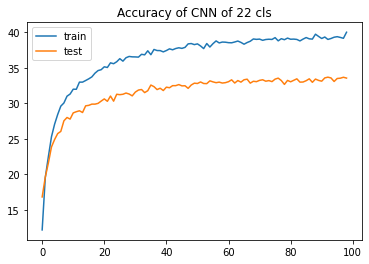

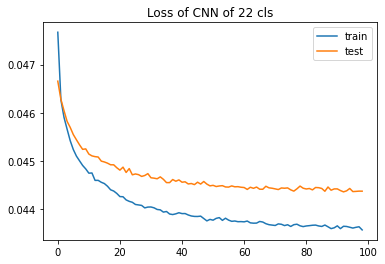

In [28]:
plt.figure(1)
plt.plot(trainAccu)
plt.plot(testAccu)
plt.legend(['train', 'test'])
plt.title('Accuracy of CNN of 22 cls')

plt.figure(2)
plt.plot(trainLoss)
plt.plot(testLoss)
plt.legend(['train', 'test'])
plt.title('Loss of CNN of 22 cls')

## PCA Result

accuracy: 0.480


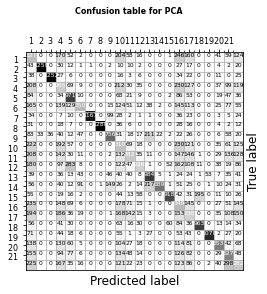

In [39]:
trainData = np.array(pd.read_csv('train_all.csv'), dtype=np.float32)
testData = np.array(pd.read_csv('test_all.csv'), dtype=np.float32)
train_x = trainData[:, :-1]
test_x = testData[:, :-1]
train_x = (train_x - np.mean(train_x, axis=0)) / np.std(train_x, axis=0)
test_x = (test_x - np.mean(test_x, axis=0)) / np.std(test_x, axis=0)
train_y = trainData[:, -1]
train_y = np.array(train_y, dtype=np.int64)
test_y = testData[:, -1]
test_y = np.array(test_y, dtype=np.int64)

n_pc = 30

pca = PCA_TE(n_pc, train_x, train_y, test_x, test_y)
confusion_matrix2(test_y, pca, 'Confusion table for PCA')